In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
from keras import models, ops
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import svm, linear_model



# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
epochs = 100
batch = 1024

In [2]:
root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
predictions_path = f"{root}/datasets/{dataset_name}_predictions.npz"
siamese_save_path = f"{root}/models/{dataset_name}_siamese.keras"
classifier_path = f"{root}/models/{dataset_name}_classifier.keras"

## MODELS
def distance(vects):
    """
    Computes the cosine distance between pairs of vectors.
    """
    x, y = vects[:,0], vects[:,1]
    x = ops.normalize(x, axis=1)
    y = ops.normalize(y, axis=1)
    return ops.sum(x * y, axis=1)

@keras.saving.register_keras_serializable()
def contrastive_Sig_loss(y_true, y_pred):
    z = (0.5 - y_true) * 2  # z = 1 per D+, z = -1 per D-
    dist = distance(y_pred)

    similarity = ops.negative(1.0 * dist) + 0.0
    denomiator = 1 + ops.exp(z * similarity)
    batch_loss = ops.log(1 / denomiator)
    return ops.negative(ops.mean(batch_loss))

classifier = models.load_model(classifier_path)
best_siamese = models.load_model(siamese_save_path)
correction = best_siamese.get_layer('correction')

In [3]:
## DATASET
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

## DATASET PREDICTIONS
y_train_pred = classifier.predict(x_train, verbose=0)
y_val_pred = classifier.predict(x_val, verbose=0)
y_test_pred = classifier.predict(x_test, verbose=0)

## DATASET MODIFICATION
x_train_modified = correction(x_train)
x_val_modified = correction(x_val)
x_test_modified = correction(x_test)
n_components = x_train_modified.shape[1]

## BALANCE CLASSES
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)
total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}

# T-SNE MODIFIED
tsne = TSNE(n_components=n_components, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)
x_val_tsne = tsne.fit_transform(x_val)
x_test_tsne = tsne.fit_transform(x_test)

# PCA MODIFIED
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.fit_transform(x_val)
x_test_pca = pca.fit_transform(x_test)

In [4]:
all_datasets = {
    'original': (x_train, x_val, x_test),
    'tsne': (x_train_tsne, x_val_tsne, x_test_tsne),
    'pca': (x_train_pca, x_val_pca, x_test_pca),
    'modified': (x_train_modified, x_val_modified, x_test_modified),
    'y': (y_train, y_val, y_test),
}

In [5]:
## EVALUATION ALL THE CLASSIFIERS
class ModelToEvaluate:
    def __init__(self, name:str, dataset: tuple, model, call_func):
        self.name = name
        self.model = model
        self.call_func = call_func

        self.x_train = dataset[0]
        self.x_val = dataset[1]
        self.x_test = dataset[2]

    def evaluate(self):
        kwargs = {'verbose': 0} if isinstance(self.model, keras.Model) or isinstance(self.model, keras.Sequential) else {}
        self.y_train_pred = self.call_func(self.model.predict(self.x_train, **kwargs))
        self.y_val_pred = self.call_func(self.model.predict(self.x_val, **kwargs))
        self.y_test_pred = self.call_func(self.model.predict(self.x_test, **kwargs))

    def fit(self):
        print(f"Training {self.name} model...")
        if isinstance(self.model, keras.Model) or isinstance(self.model, keras.Sequential):
            kwargs = {
                'validation_data': (self.x_val, y_val),
                'verbose': 0,
                'epochs': epochs,
                'batch_size': batch,
                'class_weight': class_weights,
                'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)]
            }
            self.model.fit(self.x_train, y_train, **kwargs)
        elif isinstance(self.model, sklearn.base.BaseEstimator):
            self.model.fit(self.x_train, y_train)
        else:
            raise ValueError("Model type not supported for training.")

    def print_results(self):
        titles_data = ["Training", "Validation", "Test"]
        true_labels = all_datasets['y']
        prediction = [self.y_train_pred, self.y_val_pred, self.y_test_pred]

        list_data = zip(titles_data, true_labels, prediction)
        _, axes = plt.subplots(1, len(titles_data), figsize=None)

        for i, (title_data, yy_true, yy_pred) in enumerate(list_data):
            ConfusionMatrixDisplay.from_predictions(
                yy_true, yy_pred,
                normalize='true',
                display_labels=[i for i in range(total_classes)],
                cmap=plt.cm.Blues,
                colorbar=False,
                ax=axes[i]
            )
            axes[i].set_title(f"{self.name} {title_data}\n"
                                + f"Accuracy: {balanced_accuracy_score(yy_true, yy_pred):.2%}\n"
                                + f"F1-Score: {f1_score(yy_true, yy_pred):.2f}")
        plt.tight_layout()
        plt.show()

In [6]:
classifier_mlp = keras.models.Sequential()
classifier_mlp.add(keras.layers.InputLayer(shape=(n_components,)))
classifier_mlp.add(keras.layers.Dense(n_components))
classifier_mlp.add(keras.layers.LeakyReLU())
classifier_mlp.add(keras.layers.Dense(total_classes, activation='softmax'))
classifier_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

models = [
    ModelToEvaluate("MLP tsne", all_datasets['tsne'], keras.models.clone_model(classifier_mlp), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("MLP pca", all_datasets['pca'], keras.models.clone_model(classifier_mlp), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("MLP mod", all_datasets['modified'], keras.models.clone_model(classifier_mlp), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("LR", all_datasets['original'], linear_model.LogisticRegression(max_iter=1000), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("LR tsne", all_datasets['tsne'], linear_model.LogisticRegression(max_iter=1000), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("LR pca", all_datasets['pca'], linear_model.LogisticRegression(max_iter=1000), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("LR mod", all_datasets['modified'], linear_model.LogisticRegression(max_iter=1000), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("SVM", all_datasets['original'], svm.SVC(), lambda preds: preds),
    ModelToEvaluate("SVM tsne", all_datasets['tsne'], svm.SVC(), lambda preds: preds),
    ModelToEvaluate("SVM pca", all_datasets['pca'], svm.SVC(), lambda preds: preds),
    ModelToEvaluate("SVM mod", all_datasets['modified'], svm.SVC(), lambda preds: preds)
]

for m in models:
    m.fit()
    m.evaluate()

original = ModelToEvaluate("MLP", all_datasets['original'], keras.models.clone_model(classifier), lambda preds: ops.argmax(preds, axis=1))
original.y_train_pred = y_train_pred.argmax(axis=1)
original.y_val_pred = y_val_pred.argmax(axis=1)
original.y_test_pred = y_test_pred.argmax(axis=1)

models = [original, *models]

Training MLP tsne model...
Training MLP pca model...
Training MLP mod model...
Training LR model...
Training LR tsne model...
Training LR pca model...
Training LR mod model...
Training SVM model...
Training SVM tsne model...
Training SVM pca model...
Training SVM mod model...


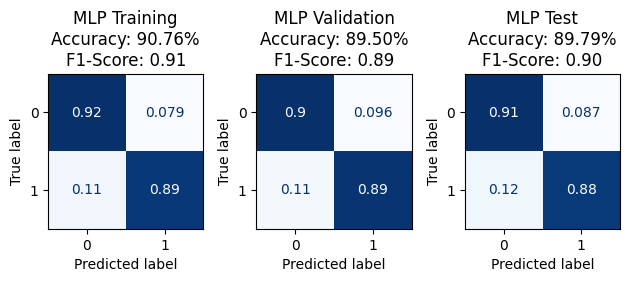

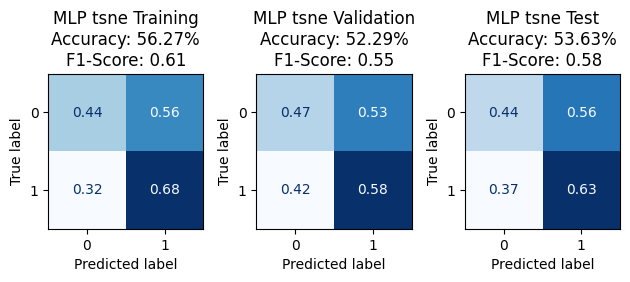

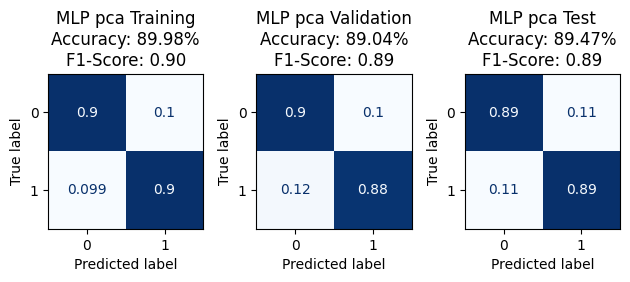

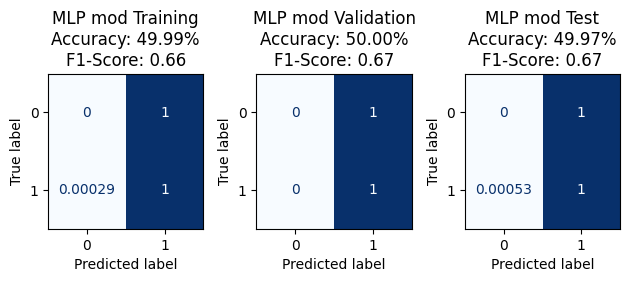

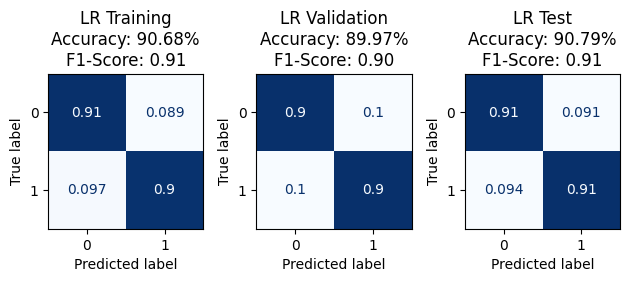

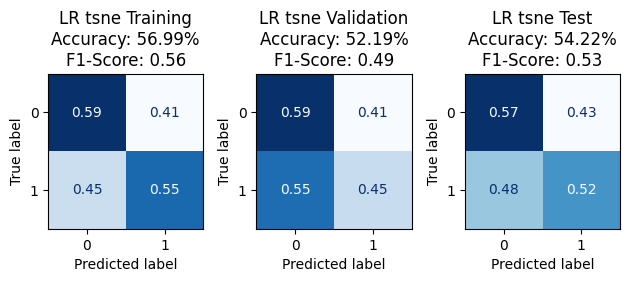

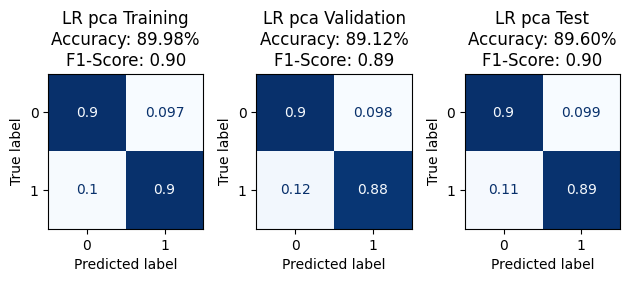

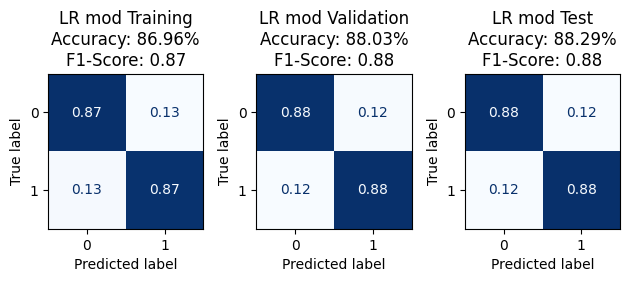

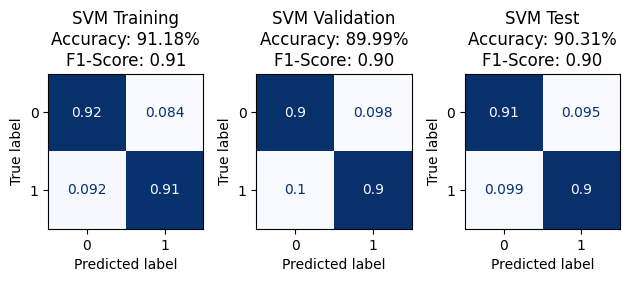

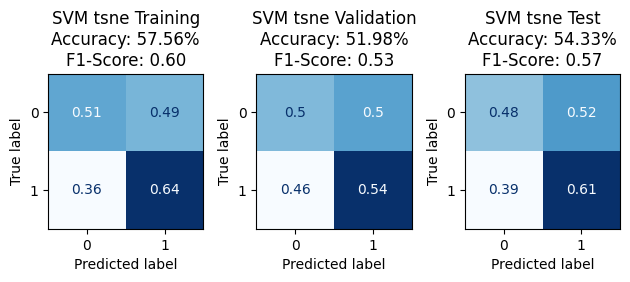

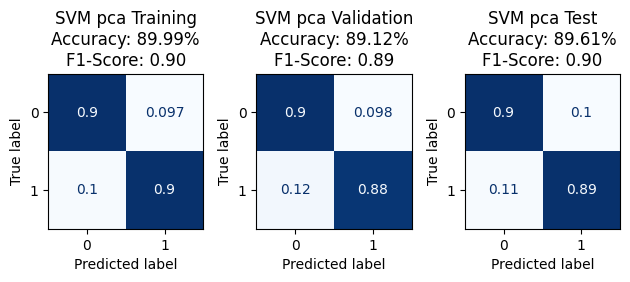

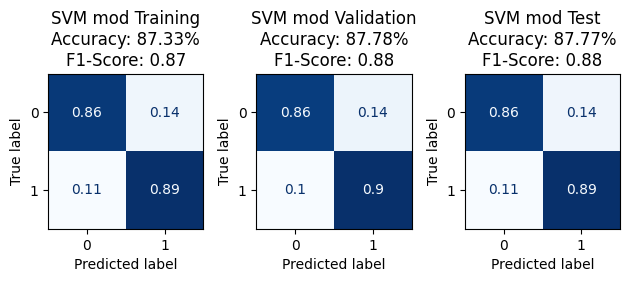

In [7]:
for m in models:
    m.print_results()

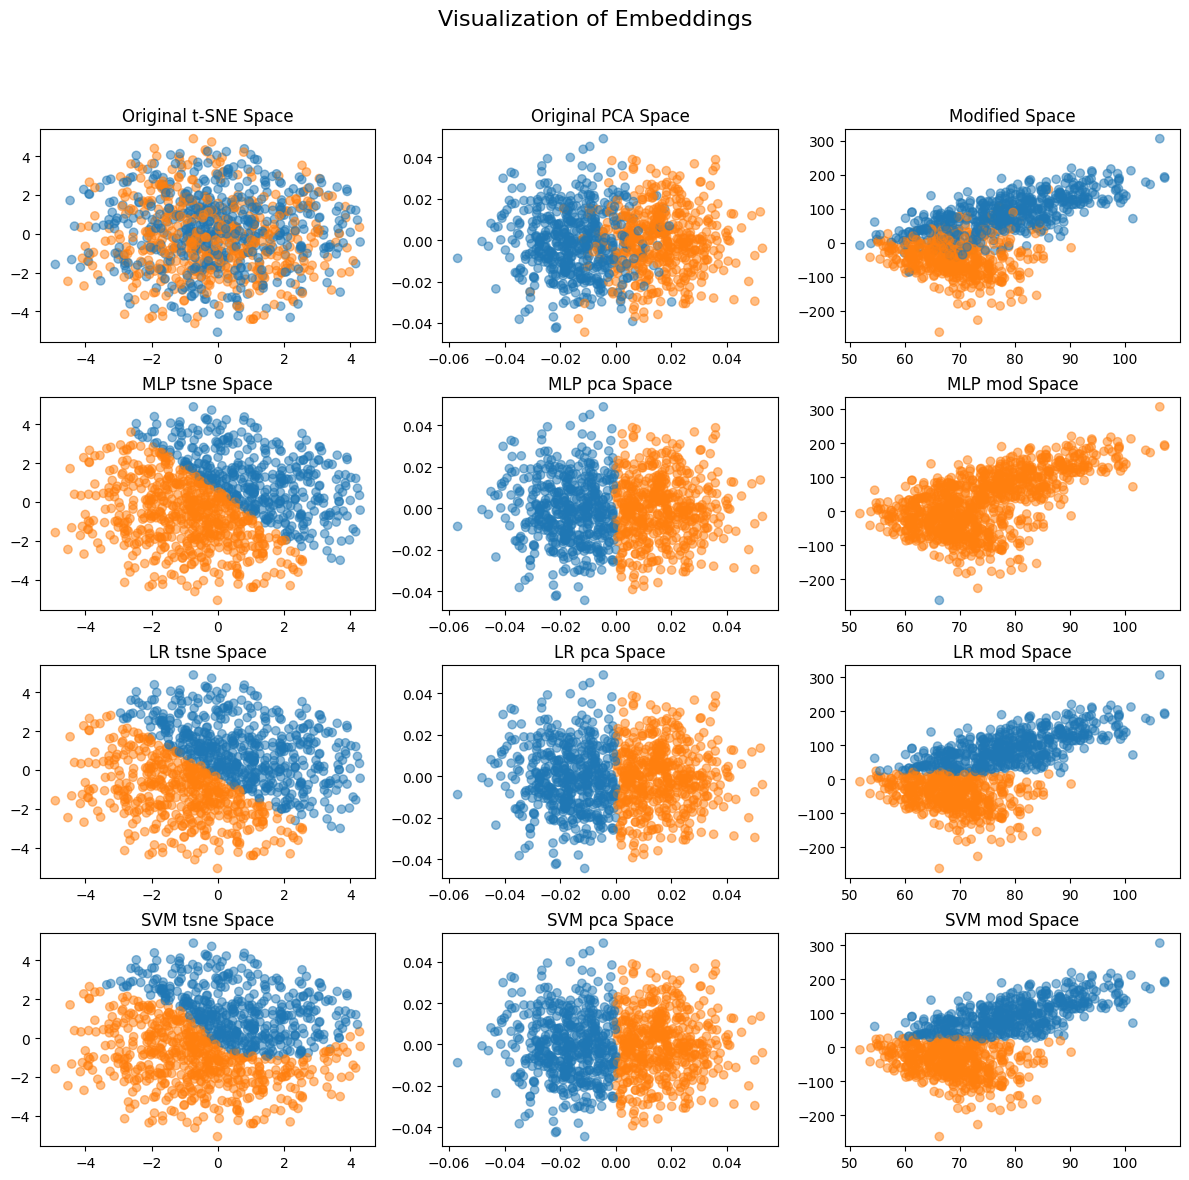

In [9]:
# Plot the t-SNE embeddings
sample_size = 1000
indices = np.random.choice(len(y_test), size=min(sample_size, len(y_test)), replace=False)
colors = list(plt.cm.tab10.colors[:total_classes])

mod_t = ModelToEvaluate("Original t-SNE", (0, 0, x_test_tsne), None, None)
mod_t.y_test_pred = y_test
mod_p = ModelToEvaluate("Original PCA", (0, 0, x_test_pca), None, None)
mod_p.y_test_pred = y_test
mod_m = ModelToEvaluate("Modified", (0, 0, x_test_modified), None, None)
mod_m.y_test_pred = y_test

models_to_print = [mod_t, mod_p, mod_m] + [m for m in models if m.x_train.shape[1] == 2]
subplots = len(models_to_print)

total_subplots = 3
plt.figure(figsize=(12, 3*(subplots // total_subplots)))

for i, model in enumerate(models_to_print):
    h = model.x_test[indices]
    c = [colors[i] for i in model.y_test_pred[indices]]
    title = f"{model.name} Space"

    plt.subplot(subplots // total_subplots, total_subplots, i + 1)
    plt.scatter(h[:,0], h[:,1], alpha=0.5, c=c)
    plt.title(title)

plt.tight_layout()
plt.suptitle('Visualization of Embeddings', fontsize=16)
plt.subplots_adjust(top=0.88)  # Adjust the top to make room for the title
plt.show()